# Global epistasis models with multiple latent phenotypes

In this example, we simulate deep mutational scanning libraries under a global epistasis model with **two** latent phenotypes.
We then fit global epistasis models with one and two latent phenotypes to the data, compare them, and examine how well they can predict new *unseen* multiple-mutant variants.

The overall conclusion is that using multiple latent phenotypes does not seem to be better than using just one latent phenotype, even if the data are in fact simulated under multiple latent phenotypes.
Presumably this is because of issues in the fitting of multiple latent phenotypes.

## Setup for analysis

Import Python modules / packages:

In [1]:
import random
import time
import warnings

import binarymap

import pandas as pd

from plotnine import *

import scipy

import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Now we set the parameters that define the simulation.
We try to choose parameters typical of a Bloom lab viral deep mutational scanning project.
There is a modest rate of errors in the variant calling, and a moderate bottleneck going from pre- to post-selection.
We use a short gene (60 residues) in order to ensure that the analysis doesn't take too long.
Crucially, we test libraries with a variety of mutation rates (average number of codon substitutions per variant):

In [2]:
seed = 1  # random number seed
genelength = 60  # gene length in codons
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 100  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # random noise in selections
bottleneck = (
    20  # bottleneck from pre- to post-selection as multiple of variants_per_lib
)

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter("ignore")

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [6]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library of variants
Simulate libraries of codon variants with each of the average mutation rates.

Simulate wildtype gene sequence:

In [7]:
geneseq = "".join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 60 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGACAGGATTCTTCCCTGGATAAGATGTACCGC


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function, with different libraries for each mutation rate:

In [8]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq,
    bclen=bclen,
    library_specs={
        "lib_1": {"avgmuts": avgmuts, "nvariants": variants_per_lib},
    },
    seed=seed,
)

Plot the number of amino-acid mutations per variant:

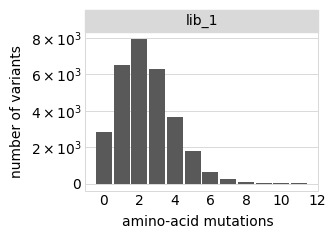

In [9]:
p = variants.plotNumMutsHistogram(
    "aa",
    samples=None,
    widthscale=1.2,
)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Average number of codon mutations of each type per variant:

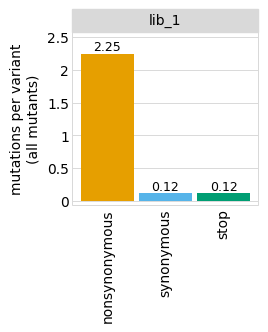

In [10]:
p = variants.plotNumCodonMutsByType(variant_type="all", samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Examine how well amino-acid mutations are sampled in the library by looking at the
fraction
of mutations seen <= some number of times, making separate plots for single mutants and all mutants.
Most mutations are samples as single mutants, and all are sampled several times as multiple mutants:

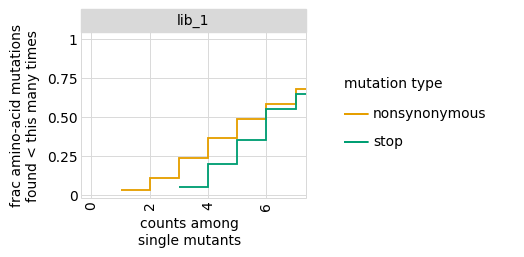

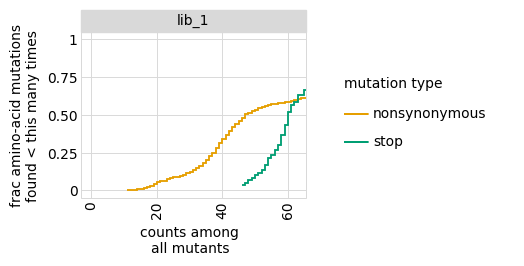

In [11]:
for variant_type in ["single", "all"]:
    p = variants.plotCumulMutCoverage(variant_type, mut_type="aa", samples=None)
    _ = p.draw(show=True)

## Simulate variant counts under two-latent phenotype global epistasis model
Now we simulate the counts of each variant after selection.
These simulations are done under a model of the phenotypic effects of mutations.

We define two latent-to-observed phenotype functions using an extension of the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214).
In that concept, there is an "observed" phenotype which is a nonlinear function of an underlying "latent" phenotype that is affected additively by mutations.

Here we instead let the observed phenotype be the sum of **two** nonlinear functions each acting on a different latent phenotype.
Each nonlinear function is implemented via a [SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator), and these are then combined in a [MultiLatentSigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.MultiLatentSigmoidPhenotypeSimulator) that maps the two latent phenotypes to the observed phenotype.
The first latent phenotype is strongly affected by most mutations (you can imagine this is something like protein stability) and the other is strongly affected by only some mutations (you can imagine this is something like protein activity).

The counts for variants are then simulated according to their enrichments, which are the exponentials of the observed phenotype:

In [12]:
pheno1 = dms_variants.simulate.SigmoidPhenotypeSimulator(
    geneseq,
    seed=seed,
    wt_latent=4,
    stop_effect=-10,
    norm_weights=[
        (0.4, -1.25, 1.25),
        (0.6, -5.5, 2.25),
    ],
)
pheno2 = dms_variants.simulate.SigmoidPhenotypeSimulator(
    geneseq,
    seed=seed,
    wt_latent=3,
    stop_effect=0,
    norm_weights=[
        (0.7, 0, 0.1),
        (0.2, -8, 3),
        (0.1, -1, 2),
    ],
)

phenosimulator = dms_variants.simulate.MultiLatentSigmoidPhenotypeSimulator(
    [pheno1, pheno2]
)

Plot the distribution of each latent phenotype, the, observed phenotype, and observed enrichment for all single amino-acid mutants, with a dashed vertical line indicating the wildtype:

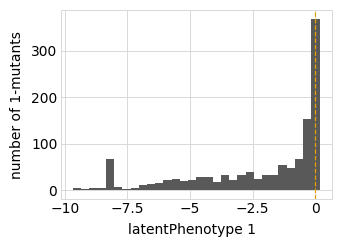

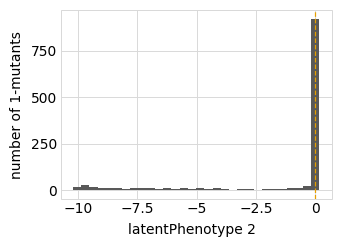

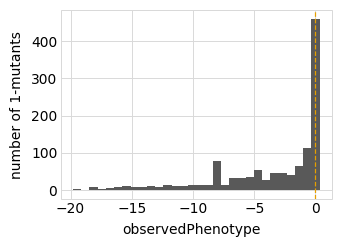

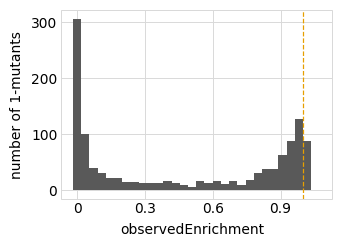

In [13]:
for value in ["latentPhenotype", "observedPhenotype", "observedEnrichment"]:
    if value == "latentPhenotype":
        for k in range(1, phenosimulator.n_latent_phenotypes + 1):
            p = phenosimulator.plotMutsHistogram(value, k=k)
            _ = p.draw(show=True)
    else:
        p = phenosimulator.plotMutsHistogram(value)
        _ = p.draw(show=True)

Use [simulateSampleCounts](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts) to simulate counts of variants when selection on each variant is proportional to
its observed enrichment:

In [14]:
counts = dms_variants.simulate.simulateSampleCounts(
    variants=variants,
    phenotype_func=phenosimulator.observedEnrichment,
    variant_error_rate=variant_error_rate,
    pre_sample={
        "total_count": variants_per_lib * avgdepth_per_variant,
        "uniformity": lib_uniformity,
    },
    pre_sample_name="pre-selection",
    post_samples={
        "post-selection": {
            "noise": noise,
            "total_count": variants_per_lib * avgdepth_per_variant,
            "bottleneck": variants_per_lib * bottleneck,
        }
    },
    seed=seed,
)

Add the simulated counts for each library to the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [15]:
variants.add_sample_counts_df(counts)

Plot the number of counts for each variant. 
The horizontal dashed line shows the total number of variants. 
The plot shows that all variants are well-sampled in the pre-selection libraries, but that post-selection some variants are sampled more or less.
This is expected since selection will decrease and increase the frequency of variants:

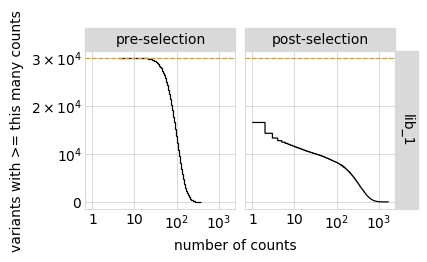

In [16]:
p = variants.plotCumulVariantCounts(libraries=variants.libraries, orientation="v")
_ = p.draw(show=True)

Distribution of the number of amino-acid mutations per variant.
As expected, mutations go down after selection:

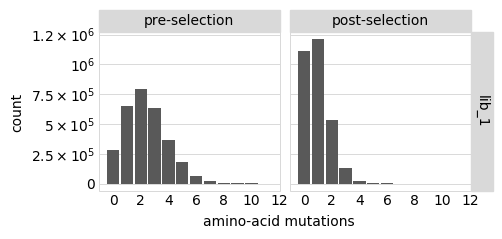

In [17]:
p = variants.plotNumMutsHistogram(
    mut_type="aa", libraries=variants.libraries, widthscale=1.2, orientation="v"
)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Average number of mutations per variant:

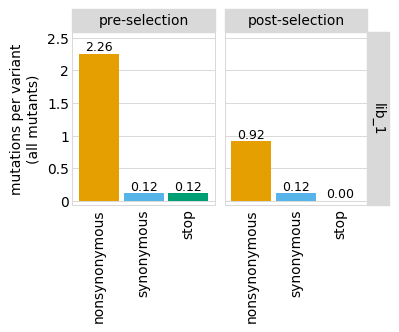

In [18]:
p = variants.plotNumCodonMutsByType(
    variant_type="all", libraries=variants.libraries, orientation="v"
)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

## Functional scores for variants
Use
[CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores)
to calculates a functional score for each variant based on its change in
frequency from pre- to post-selection:

In [19]:
func_scores = variants.func_scores("pre-selection", libraries=variants.libraries)

Classify variants
by the “types” of mutations they
have using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants):

In [20]:
func_scores = dms_variants.codonvarianttable.CodonVariantTable.classifyVariants(
    func_scores
)

Plot the distributions of scores, coloring by the variant class:

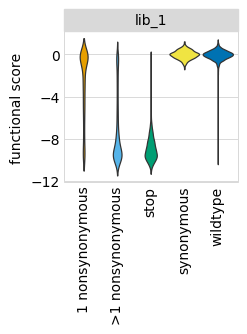

In [21]:
p = (
    ggplot(func_scores, aes("variant_class", "func_score"))
    + geom_violin(aes(fill="variant_class"))
    + ylab("functional score")
    + xlab("")
    + facet_wrap("~ library", nrow=1)
    + theme(
        figure_size=(2.25 * len(variants.libraries), 2),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + scale_fill_manual(values=CBPALETTE[1:], guide=False)
)
_ = p.draw(show=True)

## Fit global epistasis models with multiple latent phenotypes
Now we will fit global epistasis models with multiple latent phenotypes.
More information about these models is provided in the description at the top of the [dms_variants.globalepistasis](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html) module. 

We use the [fit_models](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.fit_models) function, which fits a non-epistatic model as well as global epistasis models with multiple latent phenotypes (it keeps adding latent phenotypes until their addition no longer helps).
This is the best way to fit multi-latent phenotype models, because the model with $K$ latent phenotypes is fit with parameters initialized by the model with $K - 1$ latent phenotyes.
Note [fit_models](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.fit_models) does **not** fit multi-latent phenotype models for the no-epistasis models, since this would not make sense: the sum of two linear models is just another linear model.

When calling [fit_models](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#dms_variants.globalepistasis.fit_models), we have to decide the maximum number of latent phenotypes we allow.
Here we cap it at two, because this is the actual number in the simulated data; also the computational time needed for fitting grows rapidly with more latent phenotypes:

In [22]:
# make sure we're just fitting one library, if multiple you should fit one-by-one
assert func_scores["library"].nunique() == 1

# create BinaryMap of variants
bmap = binarymap.BinaryMap(func_scores)

# fit the models
fits_df = dms_variants.globalepistasis.fit_models(
    binarymap=bmap, likelihood="Gaussian", max_latent_phenotypes=2
)

The returned `fits_df` data frame has columns with lots of relevant information:

In [23]:
fits_df.columns.tolist()

['description',
 'n_latent_phenotypes',
 'AIC',
 'nparams',
 'log_likelihood',
 'model',
 'fitting_time']

The `model` column has the actual fit model, so for now let's look at all the other columns that summarize the model fits.
You can see that models are ranked by [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion), which is an overall measure that compares model fit (log likelihood) after correcting for number of parameters.
There is also a column that gives the time (in seconds) required for the fitting:

In [24]:
# NBVAL_IGNORE_OUTPUT

fits_df.drop("model", axis="columns").round(1)

,description,n_latent_phenotypes,AIC,nparams,log_likelihood,fitting_time
0,global epistasis with 2 latent phenotypes,2,79240.3,2415,-37205.2,105.2
1,global epistasis with 1 latent phenotypes,1,79540.6,1208,-38562.3,43.6
2,no epistasis,1,133443.5,1202,-65519.8,0.3


Above we see that both global epistasis models are much better than the no-epistasis model, and that the model with two latent phenotypes is better than the one with just one: it has a better log likelihood, and the [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) shows that this improved log likelihood is enough to justify the additional parameters.

## Examine model fits
Now let's examine how the model fits the data.

### Predictions of phenotypes of fit variants
First, we see how well the model predictions align with the (simulated) measurements on the variants used to fit the models.

To do this, we use the fit models in the `model` column of `fits_df` to get a data frame with each models predicted phenotypes on all variants used to fit the models:

In [25]:
# NBVAL_IGNORE_OUTPUT

phenotypes_df = pd.concat(
    [
        tup.model.phenotypes_df.assign(model=tup.description)
        for tup in fits_df.itertuples()
    ],
    sort=False,
    ignore_index=True,
)

phenotypes_df.round(3)

,aa_substitutions,func_score,func_score_var,latent_phenotype_1,latent_phenotype_2,observed_phenotype,model,latent_phenotype
0,,0.198,0.007,0.000,0.000,-0.032,global epistasis with 2 latent phenotypes,NaN
1,M32K L34R,-1.919,0.011,-0.609,-0.302,-1.903,global epistasis with 2 latent phenotypes,NaN
2,S11A R12K R60S,-11.482,4.168,-2.559,3.550,-3.533,global epistasis with 2 latent phenotypes,NaN
3,R12Y V13N,-11.422,4.169,-6.005,-3.337,-9.297,global epistasis with 2 latent phenotypes,NaN
4,L5A S54R,-0.125,0.008,-0.193,-0.315,-0.284,global epistasis with 2 latent phenotypes,NaN
...,...,...,...,...,...,...,...,...
89995,,-6.216,4.382,NaN,NaN,-0.890,no epistasis,-0.890
89996,L23Q,-4.471,1.632,NaN,NaN,-4.972,no epistasis,-4.972
89997,V3K,-2.886,0.707,NaN,NaN,-4.031,no epistasis,-4.031
89998,R6Q D22V Y59G,-3.249,0.840,NaN,NaN,-3.198,no epistasis,-3.198


Now plot the experimentally measured functional scores versus the observed phenotype predicted by the model:

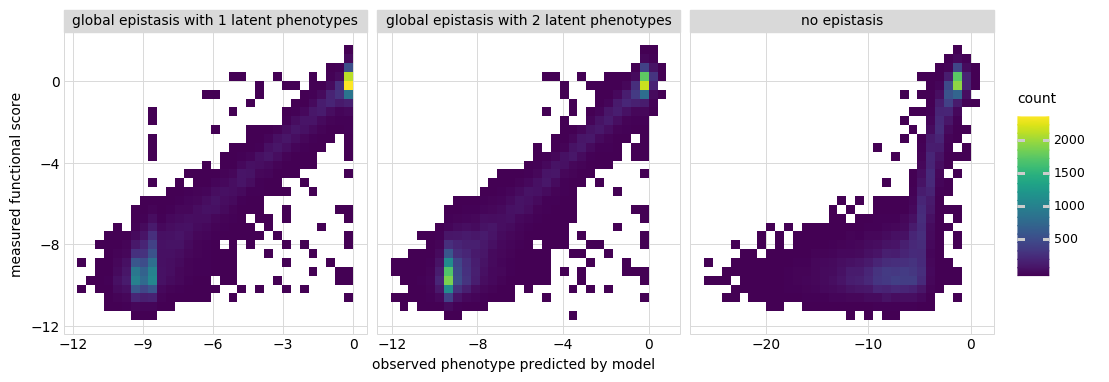

In [26]:
p = (
    ggplot(phenotypes_df, aes("observed_phenotype", "func_score"))
    + geom_bin2d()
    + facet_wrap("~ model", nrow=1, scales="free_x")
    + theme(figure_size=(4 * phenotypes_df["model"].nunique(), 4))
    + xlab("observed phenotype predicted by model")
    + ylab("measured functional score")
)
_ = p.draw(show=True)

### Distribution of latent effects
For the model with two latent phenotypes, look at the distribution of the latent effects for the two latent phenotypes, and the correlation among them.
First, get these latent effects:

In [28]:
# NBVAL_IGNORE_OUTPUT

# 2-latent phenotype model should be the first one if `fits_df`
# is sorted by descending log likelihood
model_2latent = fits_df.sort_values("log_likelihood", ascending=False)["model"].values[
    0
]
assert model_2latent.n_latent_phenotypes == 2

latenteffects2 = model_2latent.latent_effects_df.assign(
    latent_phenotype_name=lambda x: (
        "latent phenotype " + x["latent_phenotype_number"].astype(str)
    )
)
latenteffects2.round(3)

,mutation,latent_effect,latent_phenotype_number,latent_phenotype_name
0,R1*,-1.334,1,latent phenotype 1
1,R1A,-0.003,1,latent phenotype 1
2,R1C,-0.332,1,latent phenotype 1
3,R1D,-1.031,1,latent phenotype 1
4,R1E,-0.976,1,latent phenotype 1
...,...,...,...,...
2395,R60S,1.606,2,latent phenotype 2
2396,R60T,-0.379,2,latent phenotype 2
2397,R60V,-0.904,2,latent phenotype 2
2398,R60W,-2.811,2,latent phenotype 2


Distribution of latent effects for the two phenotypes:

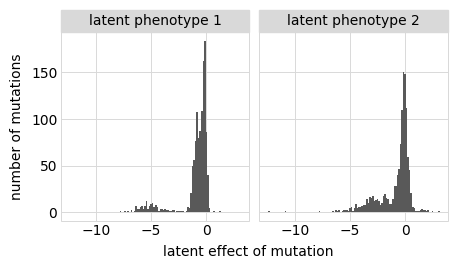

In [29]:
p = (
    ggplot(latenteffects2, aes("latent_effect"))
    + geom_histogram()
    + facet_wrap("~ latent_phenotype_name", nrow=1)
    + theme(figure_size=(2.5 * model_2latent.n_latent_phenotypes, 2.5))
    + xlab("latent effect of mutation")
    + ylab("number of mutations")
)
_ = p.draw(show=True)

Correlation between latent effects of all single mutations for the two phenotypes:

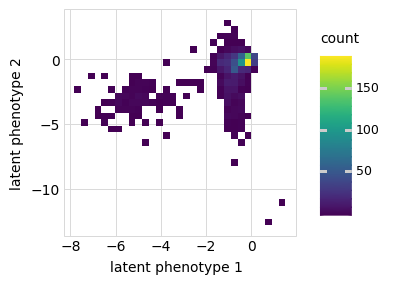

In [30]:
p = (
    ggplot(
        latenteffects2.pivot_table(
            index="mutation", values="latent_effect", columns="latent_phenotype_name"
        ),
        aes("latent phenotype 1", "latent phenotype 2"),
    )
    + geom_bin2d()
    + theme(figure_size=(3, 3))
)
_ = p.draw(show=True)

### Predicted versus true latent effects
Now let's see how the model-predicted latent effects correlate with the true latent effects in the simulation for the two-latent phenotype model.

First, get a data frame with the **true** (from simulation) latent effects of each mutation on each latent phenotype number:

In [31]:
# NBVAL_IGNORE_OUTPUT

actual_latenteffects2 = pd.concat(
    [
        latenteffects2[["mutation"]]
        .drop_duplicates()
        .assign(
            actual_effect=lambda x: (
                x["mutation"].map(
                    lambda m: phenosimulator.latentPhenotype(m, k)
                    - phenosimulator.latentPhenotype("", k)
                )
            ),
            actual_number=f"actual {k}",
        )
        for k in range(1, phenosimulator.n_latent_phenotypes + 1)
    ],
    sort=False,
    ignore_index=True,
)

actual_latenteffects2.round(3)

,mutation,actual_effect,actual_number
0,R1*,-8.152,actual 1
1,R1A,-0.001,actual 1
2,R1C,-0.421,actual 1
3,R1D,-6.496,actual 1
4,R1E,-1.359,actual 1
...,...,...,...
2395,R60S,-0.010,actual 2
2396,R60T,-0.004,actual 2
2397,R60V,-0.009,actual 2
2398,R60W,-0.001,actual 2


Get a comparable data frame for the model-predicted latent effects:

In [32]:
# NBVAL_IGNORE_OUTPUT

predicted_latenteffects2 = latenteffects2.rename(
    columns={"latent_effect": "predicted_effect"}
).assign(
    predicted_number=lambda x: "predicted " + x["latent_phenotype_number"].astype(str)
)[
    ["mutation", "predicted_effect", "predicted_number"]
]

predicted_latenteffects2.round(3)

,mutation,predicted_effect,predicted_number
0,R1*,-1.334,predicted 1
1,R1A,-0.003,predicted 1
2,R1C,-0.332,predicted 1
3,R1D,-1.031,predicted 1
4,R1E,-0.976,predicted 1
...,...,...,...
2395,R60S,1.606,predicted 2
2396,R60T,-0.379,predicted 2
2397,R60V,-0.904,predicted 2
2398,R60W,-2.811,predicted 2


Now get a data frame with all combinations of predictions and actual latent effects:

In [33]:
# NBVAL_IGNORE_OUTPUT

actual_vs_predicted_latenteffects2 = pd.merge(
    actual_latenteffects2, predicted_latenteffects2, on="mutation"
)

actual_vs_predicted_latenteffects2.round(3)

,mutation,actual_effect,actual_number,predicted_effect,predicted_number
0,R1*,-8.152,actual 1,-1.334,predicted 1
1,R1*,-8.152,actual 1,0.066,predicted 2
2,R1*,0.000,actual 2,-1.334,predicted 1
3,R1*,0.000,actual 2,0.066,predicted 2
4,R1A,-0.001,actual 1,-0.003,predicted 1
...,...,...,...,...,...
4795,R60W,-0.001,actual 2,-2.811,predicted 2
4796,R60Y,-0.033,actual 1,-0.109,predicted 1
4797,R60Y,-0.033,actual 1,0.040,predicted 2
4798,R60Y,0.002,actual 2,-0.109,predicted 1


Plot the correlations between the actual and predicted values:

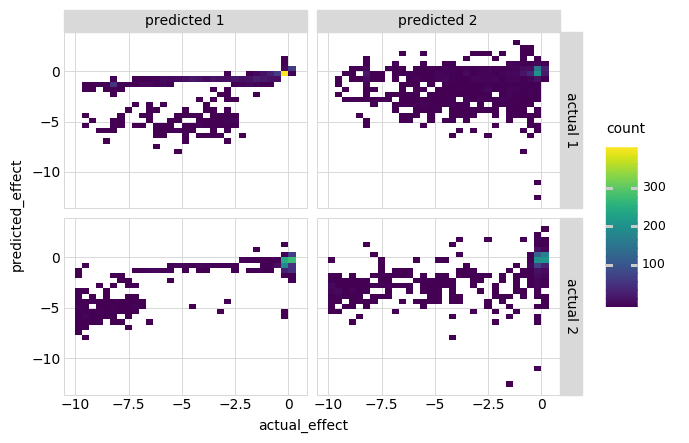

In [34]:
p = (
    ggplot(actual_vs_predicted_latenteffects2, aes("actual_effect", "predicted_effect"))
    + geom_bin2d()
    + facet_grid("actual_number ~ predicted_number", scales="free")
)
_ = p.draw(show=True)

## Model predictions on new variants
Generate some quadruple codon mutants (almost all of which will correspond to sequences never seen by the model) and predict the experimental enrichments from their observed phenotypes with each model (recall that the observed phenotype is proportional to the log enrichment).
Compare these to the true values from the phenotype simulator.

First, simulate some variants:

In [35]:
# NBVAL_IGNORE_OUTPUT

random.seed(1)

nmuts = 4  # predict variants with this many mutations relative to wildtype
npredict = 50000  # make predictions for this many variants

rand_variants_df = pd.DataFrame(
    {"codon_substitutions": dms_variants.simulate.codon_muts(geneseq, nmuts, npredict)}
).assign(
    aa_substitutions=lambda x: x["codon_substitutions"].map(
        dms_variants.codonvarianttable.CodonVariantTable.codonToAAMuts
    ),
    true_enrichment=lambda x: x["aa_substitutions"].map(
        phenosimulator.observedEnrichment
    ),
)

rand_variants_df

,codon_substitutions,aa_substitutions,true_enrichment
0,ACC9TAC TCC37ACA GAT52CAA CTG55ACT,T9Y S37T D52Q L55T,0.000005
1,CGG29GGG ATG31CGC ATG32TAT TCA49ATC,R29G M31R M32Y S49I,0.000002
2,TCC2TCG GCT7CGA ATG32CTA ATG58GCT,A7R M32L M58A,0.000001
3,AGA1CTC GTA45CAC TCA49GTG GGA50TCA,R1L V45H S49V G50S,0.005773
4,GCT7CCA CGT15AAC GAC38AAC ATG58AAC,A7P R15N D38N M58N,0.000001
...,...,...,...
49995,GTA16ATG CCT24AGA GTA45CAC CTG55TCC,V16M P24R V45H L55S,0.000660
49996,GTG3TTT CTG5CGC TCA11GGA TCG42TAC,V3F L5R S11G S42Y,0.005104
49997,ATC17TAC CTA34TCG TTT41TGT CCA44CTG,I17Y L34S F41C P44L,0.001696
49998,CGG29CGT CCA44TAA CTG55GAC TAC59GCG,P44* L55D Y59A,0.000999


Now add the model-predicted enrichments:

In [36]:
# NBVAL_IGNORE_OUTPUT

actual_vs_predicted_enrichments = []
for tup in fits_df.itertuples():
    actual_vs_predicted_enrichments.append(
        tup.model.add_phenotypes_to_df(rand_variants_df, unknown_as_nan=True)
        .dropna(axis="index")
        .assign(
            model_description=tup.description,
            predicted_enrichment=lambda x: tup.model.enrichments(
                x["observed_phenotype"]
            ),
        )[
            [
                "aa_substitutions",
                "true_enrichment",
                "model_description",
                "predicted_enrichment",
            ]
        ]
    )
actual_vs_predicted_enrichments = pd.concat(
    actual_vs_predicted_enrichments, sort=False, ignore_index=True
)
actual_vs_predicted_enrichments

,aa_substitutions,true_enrichment,model_description,predicted_enrichment
0,T9Y S37T D52Q L55T,0.000005,global epistasis with 2 latent phenotypes,0.002543
1,R29G M31R M32Y S49I,0.000002,global epistasis with 2 latent phenotypes,0.001573
2,A7R M32L M58A,0.000001,global epistasis with 2 latent phenotypes,0.001530
3,R1L V45H S49V G50S,0.005773,global epistasis with 2 latent phenotypes,0.009391
4,A7P R15N D38N M58N,0.000001,global epistasis with 2 latent phenotypes,0.001557
...,...,...,...,...
149995,V16M P24R V45H L55S,0.000660,no epistasis,0.010272
149996,V3F L5R S11G S42Y,0.005104,no epistasis,0.121759
149997,I17Y L34S F41C P44L,0.001696,no epistasis,0.081950
149998,P44* L55D Y59A,0.000999,no epistasis,0.011766


Plot the predictions versus the true enrichments for each model:

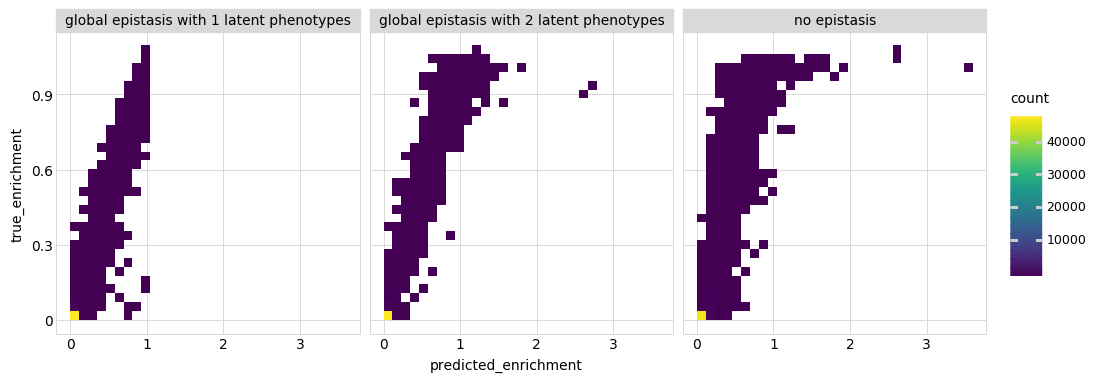

In [37]:
p = (
    ggplot(
        actual_vs_predicted_enrichments, aes("predicted_enrichment", "true_enrichment")
    )
    + geom_bin2d()
    + facet_wrap("~ model_description", nrow=1)
    + theme(
        figure_size=(
            4 * actual_vs_predicted_enrichments["model_description"].nunique(),
            4,
        )
    )
)
_ = p.draw(show=True)

Calculate the correlations between predicted and true enrichments:

In [38]:
# NBVAL_IGNORE_OUTPUT

(
    actual_vs_predicted_enrichments.groupby("model_description")
    .apply(lambda x: x["predicted_enrichment"].corr(x["true_enrichment"]))
    .rename("correlation")
    .to_frame()
    .round(3)
)

,correlation
model_description,
global epistasis with 1 latent phenotypes,0.987
global epistasis with 2 latent phenotypes,0.978
no epistasis,0.871
